初始B4

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import random
import openpyxl

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# 贝叶斯更新函数
def bayesian_update(k, n, alpha_prior=1, beta_prior=1):
    alpha_post = alpha_prior + k
    beta_post = beta_prior + (n - k)
    return alpha_post, beta_post

# 计算期望次品率
def expected_defective_rate(alpha_post, beta_post):
    return alpha_post / (alpha_post + beta_post)

# 计算总成本和成品次品率的函数
def calc_total_cost(case, detect_parts1=True, detect_parts2=True, detect_final=True, dismantle=True):
    n_parts1 = 100  # 零配件1的数量
    n_parts2 = 100  # 零配件2的数量
    cost_parts1 = n_parts1 * case['零配件1检测成本'] if detect_parts1 else 0  # 零配件1的检测成本
    cost_parts2 = n_parts2 * case['零配件2检测成本'] if detect_parts2 else 0  # 零配件2的检测成本

    loss_parts1 = (n_parts1 * case['零配件1次品率']) * (case['装配成本']) if not detect_parts1 else 0  # 零配件1的次品损失
    loss_parts2 = (n_parts2 * case['零配件2次品率']) * (case['装配成本']) if not detect_parts2 else 0  # 零配件2的次品损失

    n_final_products = 100  # 成品数量
    cost_final = n_final_products * case['成品检测成本'] if detect_final else 0  # 成品的检测成本
    loss_final = (n_final_products * case['成品次品率']) * case['调换损失'] if not detect_final else 0  # 成品的次品损失

    dismantle_cost = n_final_products * case['拆解费用'] if dismantle else 0  # 拆解费用
    dismantle_revenue = (n_final_products * case['成品次品率']) * case['市场售价'] if dismantle else 0  # 拆解收益

    total_cost = (cost_parts1 + cost_parts2 + loss_parts1 + loss_parts2 +
                  cost_final + loss_final + dismantle_cost - dismantle_revenue)  # 总成本

    defective_rate = case['成品次品率'] * (1 if detect_final else 0.5)  # 成品次品率

    return total_cost, defective_rate

# 适应度函数：计算策略的总成本的负值（因为我们希望最小化总成本）
def fitness_function(strategy, case):
    total_cost, _ = calc_total_cost(case, **strategy)
    return -total_cost

# 初始化种群：生成初始策略组合
def initialize_population(population_size):
    return [{
        "detect_parts1": random.choice([True, False]),
        "detect_parts2": random.choice([True, False]),
        "detect_final": random.choice([True, False]),
        "dismantle": random.choice([True, False])
    } for _ in range(population_size)]

# 选择操作：选择适应度较高的个体进行繁殖
def selection(population, fitnesses, num_parents):
    parents = []
    for _ in range(num_parents):
        max_fitness_index = fitnesses.index(max(fitnesses))
        parents.append(population[max_fitness_index])
        fitnesses[max_fitness_index] = float('-inf')
    return parents

# 变异操作：引入新的基因
def mutation(strategy, mutation_rate):
    for key in strategy:
        if random.random() < mutation_rate:
            strategy[key] = not strategy[key]
    return strategy

# 遗传算法主循环
def genetic_algorithm(case, population_size=100, num_generations=100, mutation_rate=0.01):
    population = initialize_population(population_size)
    for _ in range(num_generations):
        fitnesses = [fitness_function(strategy, case) for strategy in population]
        parents = selection(population, fitnesses, population_size // 2)
        new_population = parents[:]
        while len(new_population) < population_size:
            parent = random.choice(parents)
            child = mutation(parent, mutation_rate)
            new_population.append(child)
        population = new_population
    best_strategy = population[fitnesses.index(max(fitnesses))]
    return best_strategy

# 定义不同情况的参数
scenarios = {
    '情况1': {'零配件1': {'次品率': 0.1, '购买单价': 4, '检测成本': 2, 'k': 5, 'n': 50},
              '零配件2': {'次品率': 0.1, '购买单价': 18, '检测成本': 3, 'k': 10, 'n': 50},
              '成品': {'次品率': 0.1, '装配成本': 6, '检测成本': 3, 'k': 8, 'n': 50}},
    '情况2': {'零配件1': {'次品率': 0.2, '购买单价': 4, '检测成本': 2, 'k': 8, 'n': 50},
              '零配件2': {'次品率': 0.2, '购买单价': 18, '检测成本': 3, 'k': 12, 'n': 50},
              '成品': {'次品率': 0.2, '装配成本': 6, '检测成本': 3, 'k': 10, 'n': 50}},
    '情况3': {'零配件1': {'次品率': 0.1, '购买单价': 4, '检测成本': 2, 'k': 6, 'n': 50},
              '零配件2': {'次品率': 0.1, '购买单价': 18, '检测成本': 3, 'k': 9, 'n': 50},
              '成品': {'次品率': 0.1, '装配成本': 6, '检测成本': 3, 'k': 7, 'n': 50}},
    '情况4': {'零配件1': {'次品率': 0.2, '购买单价': 4, '检测成本': 1, 'k': 7, 'n': 50},
              '零配件2': {'次品率': 0.2, '购买单价': 18, '检测成本': 1, 'k': 11, 'n': 50},
              '成品': {'次品率': 0.2, '装配成本': 6, '检测成本': 2, 'k': 9, 'n': 50}},
    '情况5': {'零配件1': {'次品率': 0.1, '购买单价': 4, '检测成本': 8, 'k': 4, 'n': 50},
              '零配件2': {'次品率': 0.2, '购买单价': 18, '检测成本': 1, 'k': 13, 'n': 50},
              '成品': {'次品率': 0.1, '装配成本': 6, '检测成本': 2, 'k': 6, 'n': 50}},
    '情况6': {'零配件1': {'次品率': 0.05, '购买单价': 4, '检测成本': 2, 'k': 3, 'n': 50},
              '零配件2': {'次品率': 0.05, '购买单价': 18, '检测成本': 3, 'k': 5, 'n': 50},
              '成品': {'次品率': 0.05, '装配成本': 6, '检测成本': 3, 'k': 4, 'n': 50}},
}

# 使用贝叶斯更新后的次品率进行遗传算法优化
updated_scenarios = {}
for scenario_name, scenario_data in scenarios.items():
    result = {
        '零配件1': {},
        '零配件2': {},
        '成品': {}
    }

    k1 = scenario_data['零配件1']['k']
    n1 = scenario_data['零配件1']['n']
    alpha_post1, beta_post1 = bayesian_update(k1, n1)
    updated_theta1 = expected_defective_rate(alpha_post1, beta_post1)
    result['零配件1']['次品率'] = updated_theta1

    k2 = scenario_data['零配件2']['k']
    n2 = scenario_data['零配件2']['n']
    alpha_post2, beta_post2 = bayesian_update(k2, n2)
    updated_theta2 = expected_defective_rate(alpha_post2, beta_post2)
    result['零配件2']['次品率'] = updated_theta2

    k_prod = scenario_data['成品']['k']
    n_prod = scenario_data['成品']['n']
    alpha_post_prod, beta_post_prod = bayesian_update(k_prod, n_prod)
    updated_theta_prod = expected_defective_rate(alpha_post_prod, beta_post_prod)
    result['成品']['次品率'] = updated_theta_prod

    # 将更新后的次品率应用到遗传算法
    updated_scenarios[scenario_name] = {
        '零配件1次品率': result['零配件1']['次品率'],
        '零配件2次品率': result['零配件2']['次品率'],
        '成品次品率': result['成品']['次品率'],
        '零配件1检测成本': scenario_data['零配件1']['检测成本'],
        '零配件2检测成本': scenario_data['零配件2']['检测成本'],
        '成品检测成本': scenario_data['成品']['检测成本'],
        '装配成本': scenario_data['成品']['装配成本'],
        '拆解费用': scenario_data['成品']['装配成本'],
        '市场售价': 56,
        '调换损失': 5  # 添加调换损失的值
    }

# 遗传算法优化
final_results = []
for scenario_name, case in updated_scenarios.items():
    best_strategy = genetic_algorithm(case)
    total_cost, defective_rate = calc_total_cost(case, **best_strategy)
    final_results.append({
        '情况': scenario_name,
        '最佳策略': best_strategy,
        '总成本': -fitness_function(best_strategy, case),
        '更新后的成品次品率': defective_rate
    })

# 保存结果到Excel文件
df_final = pd.DataFrame(final_results)
df_final.to_excel('遗传算法优化结果.xlsx', index=False)

# 打印优化结果
print(df_final)

# 可视化优化结果
df_final.plot(x='情况', y='总成本', kind='bar', stacked=False, figsize=(10, 6), title="各情况的优化总成本")
plt.ylabel('总成本')
plt.show()


新B4

    情况                                               最佳策略         总成本  \
0  情况1  {'detect_parts1': False, 'detect_parts2': True...   86.538462   
1  情况2  {'detect_parts1': True, 'detect_parts2': False...  626.923077   
2  情况3  {'detect_parts1': True, 'detect_parts2': True,...  800.000000   
3  情况4  {'detect_parts1': True, 'detect_parts2': False...  626.923077   
4  情况5  {'detect_parts1': True, 'detect_parts2': False...  413.461538   
5  情况6  {'detect_parts1': False, 'detect_parts2': Fals...  496.153846   

   更新后的成品次品率  
0   0.173077  
1   0.173077  
2   0.173077  
3   0.173077  
4   0.173077  
5   0.173077  


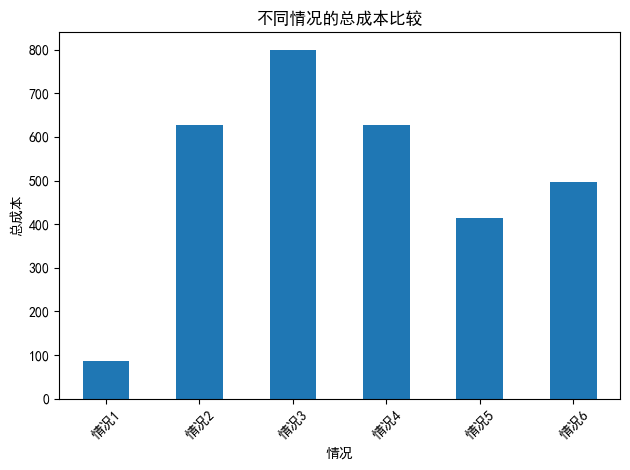

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import random
import openpyxl

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# 计算总成本的函数
def calc_total_cost(case, detect_parts1=True, detect_parts2=True, detect_final=True, dismantle=True):
    n_parts1 = 100  # 零配件1的数量
    n_parts2 = 100  # 零配件2的数量
    cost_parts1 = n_parts1 * case['零配件1检测成本'] if detect_parts1 else 0  # 零配件1的检测成本
    cost_parts2 = n_parts2 * case['零配件2检测成本'] if detect_parts2 else 0  # 零配件2的检测成本

    loss_parts1 = (n_parts1 * case['零配件1次品率']) * (case['装配成本']) if not detect_parts1 else 0  # 零配件1的次品损失
    loss_parts2 = (n_parts2 * case['零配件2次品率']) * (case['装配成本']) if not detect_parts2 else 0  # 零配件2的次品损失

    n_final_products = 100  # 成品数量
    cost_final = n_final_products * case['成品检测成本'] if detect_final else 0  # 成品的检测成本
    loss_final = (n_final_products * case['成品次品率']) * case['调换损失'] if not detect_final else 0  # 成品的次品损失

    dismantle_cost = n_final_products * case['拆解费用'] if dismantle else 0  # 拆解费用
    dismantle_revenue = (n_final_products * case['成品次品率']) * case['市场售价'] if dismantle else 0  # 拆解收益

    total_cost = (cost_parts1 + cost_parts2 + loss_parts1 + loss_parts2 +
                  cost_final + loss_final + dismantle_cost - dismantle_revenue)  # 总成本

    return total_cost

# 适应度函数：计算策略的总成本的负值（因为我们希望最小化总成本）
def fitness_function(strategy, case):
    total_cost = calc_total_cost(case, **strategy)
    return -total_cost

# 初始化种群：生成初始策略组合
def initialize_population(population_size):
    return [{
        "detect_parts1": random.choice([True, False]),
        "detect_parts2": random.choice([True, False]),
        "detect_final": random.choice([True, False]),
        "dismantle": random.choice([True, False])
    } for _ in range(population_size)]

# 选择操作：选择适应度较高的个体进行繁殖
def selection(population, fitnesses, num_parents):
    parents = []
    for _ in range(num_parents):
        max_fitness_index = fitnesses.index(max(fitnesses))
        parents.append(population[max_fitness_index])
        fitnesses[max_fitness_index] = float('-inf')
    return parents

# 变异操作：引入新的基因
def mutation(strategy, mutation_rate):
    for key in strategy:
        if random.random() < mutation_rate:
            strategy[key] = not strategy[key]
    return strategy

# 遗传算法主循环
def genetic_algorithm(case, population_size=100, num_generations=100, mutation_rate=0.01):
    population = initialize_population(population_size)
    for _ in range(num_generations):
        fitnesses = [fitness_function(strategy, case) for strategy in population]
        parents = selection(population, fitnesses, population_size // 2)
        new_population = parents[:]
        while len(new_population) < population_size:
            parent = random.choice(parents)
            child = mutation(parent, mutation_rate)
            new_population.append(child)
        population = new_population
    best_strategy = population[fitnesses.index(max(fitnesses))]
    return best_strategy

# 从文件中读取数据
df_updated = pd.read_excel('问题2零配件和成品更新次品率.xlsx')

# 定义不同情况的参数
scenarios = {
    '情况1': {'零配件1次品率': df_updated.loc[0, '零配件1_更新次品率'],
              '零配件2次品率': df_updated.loc[0, '零配件2_更新次品率'],
              '成品次品率': df_updated.loc[0, '成品_更新次品率'],
              '零配件1检测成本': 2,
              '零配件2检测成本': 3,
              '成品检测成本': 3,
              '装配成本': 6,
              '拆解费用': 6,
              '市场售价': 56,
              '调换损失': 5},
    '情况2': {'零配件1次品率': df_updated.loc[1, '零配件1_更新次品率'],
              '零配件2次品率': df_updated.loc[1, '零配件2_更新次品率'],
              '成品次品率': df_updated.loc[1, '成品_更新次品率'],
              '零配件1检测成本': 2,
              '零配件2检测成本': 3,
              '成品检测成本': 3,
              '装配成本': 6,
              '拆解费用': 6,
              '市场售价': 56,
              '调换损失': 5},
    '情况3': {'零配件1次品率': df_updated.loc[2, '零配件1_更新次品率'],
              '零配件2次品率': df_updated.loc[2, '零配件2_更新次品率'],
              '成品次品率': df_updated.loc[2, '成品_更新次品率'],
              '零配件1检测成本': 2,
              '零配件2检测成本': 3,
              '成品检测成本': 3,
              '装配成本': 6,
              '拆解费用': 6,
              '市场售价': 56,
              '调换损失': 5},
    '情况4': {'零配件1次品率': df_updated.loc[3, '零配件1_更新次品率'],
              '零配件2次品率': df_updated.loc[3, '零配件2_更新次品率'],
              '成品次品率': df_updated.loc[3, '成品_更新次品率'],
              '零配件1检测成本': 2,
              '零配件2检测成本': 3,
              '成品检测成本': 3,
              '装配成本': 6,
              '拆解费用': 6,
              '市场售价': 56,
              '调换损失': 5},
    '情况5': {'零配件1次品率': df_updated.loc[4, '零配件1_更新次品率'],
              '零配件2次品率': df_updated.loc[4, '零配件2_更新次品率'],
              '成品次品率': df_updated.loc[4, '成品_更新次品率'],
              '零配件1检测成本': 2,
              '零配件2检测成本': 3,
              '成品检测成本': 3,
              '装配成本': 6,
              '拆解费用': 6,
              '市场售价': 56,
              '调换损失': 5},
    '情况6': {'零配件1次品率': df_updated.loc[5, '零配件1_更新次品率'],
              '零配件2次品率': df_updated.loc[5, '零配件2_更新次品率'],
              '成品次品率': df_updated.loc[5, '成品_更新次品率'],
              '零配件1检测成本': 2,
              '零配件2检测成本': 3,
              '成品检测成本': 3,
              '装配成本': 6,
              '拆解费用': 6,
              '市场售价': 56,
              '调换损失': 5},
}

# 遗传算法优化
final_results = []
for scenario_name, case in scenarios.items():
    best_strategy = genetic_algorithm(case)
    total_cost = calc_total_cost(case, **best_strategy)
    final_results.append({
        '情况': scenario_name,
        '最佳策略': best_strategy,
        '总成本': -fitness_function(best_strategy, case),
        '更新后的成品次品率': case['成品次品率']  # 从表格中提取的固定成品次品率
    })

# 将结果保存到Excel
df_results = pd.DataFrame(final_results)
df_results.to_excel('B4_1优化结果.xlsx', index=False)

# 打印最终结果
print(df_results)

# 绘制图表
df_results.plot(x='情况', y='总成本', kind='bar', legend=False)
plt.title('不同情况的总成本比较')
plt.xlabel('情况')
plt.ylabel('总成本')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('总成本比较.png')  # 保存图表到文件
plt.show()
